In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p

#Limiting float output to the 2 decimal points
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [5]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Import data

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# check the number of samples and features
print('The train data size before dropping Id feature is : {}'.format(train.shape))
print('The test data size before dropping Id feature is : {}'.format(test.shape))

# Save Id columnd
train_Id = train['Id']
test_Id = test['Id']

# Drop Id column
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

# check the number of samples and features after dropping Id
print('\nThe train data size after dropping Id feature is : {}'.format(train.shape))
print('The test data size after dropping Id feature is : {}'.format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)

The train data size after dropping Id feature is : (1460, 80)
The test data size after dropping Id feature is : (1459, 79)


# Data Preprocessing

### Outliers

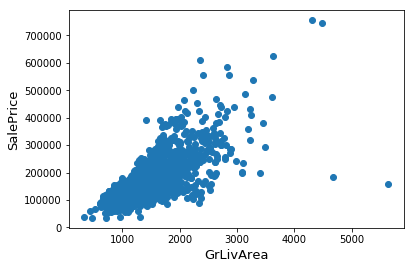

In [8]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y =train['SalePrice'])
plt.xlabel('GrLivArea', fontsize = 13)
plt.ylabel('SalePrice', fontsize = 13)
plt.show()

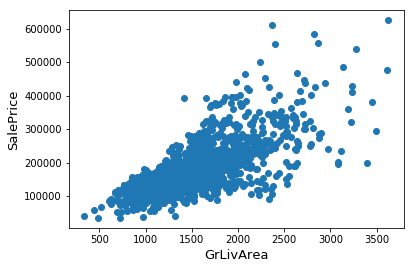

In [9]:
# delete outliers
train = train.drop(train[train['GrLivArea']>4000].index)


fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y =train['SalePrice'])
plt.xlabel('GrLivArea', fontsize = 13)
plt.ylabel('SalePrice', fontsize = 13)
plt.show()

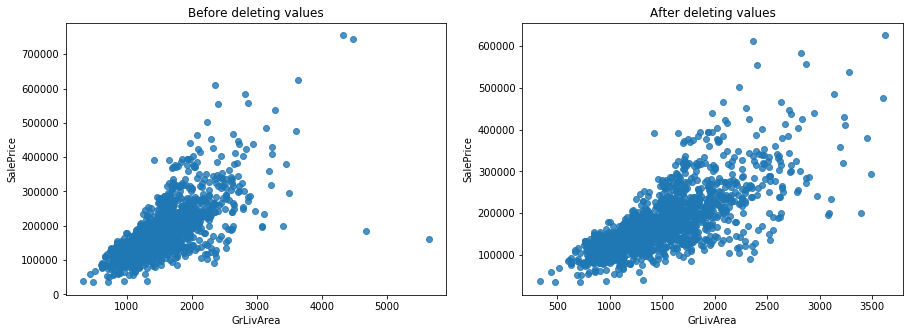

In [10]:
# The same
train2 = pd.read_csv('train.csv')

plt.subplots(figsize = (15,5))

plt.subplot(1,2,1)
g = sns.regplot(x= train2['GrLivArea'], y= train2['SalePrice'], fit_reg = False).set_title('Before deleting values')

# Delete some outliers
plt.subplot(1,2,2)
train2 = train2.drop(train2[train2['GrLivArea']>4000].index)
g = sns.regplot(x=train2['GrLivArea'], y = train2['SalePrice'], fit_reg = False).set_title('After deleting values')

# delete train2
del train2

### Inspect target Variable

In [11]:
train['SalePrice'].describe()

count     1456.00
mean    180151.23
std      76696.59
min      34900.00
25%     129900.00
50%     163000.00
75%     214000.00
max     625000.00
Name: SalePrice, dtype: float64

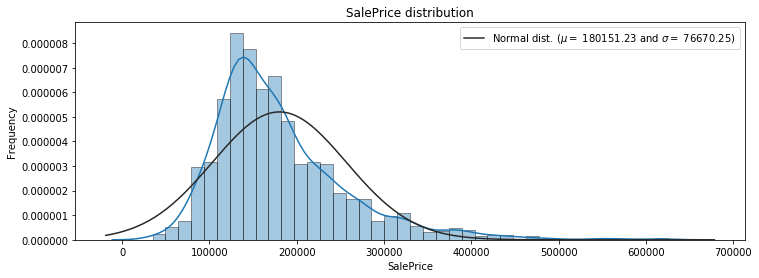

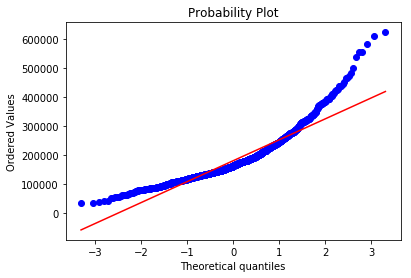

In [12]:
(mu, sigma) = norm.fit(train['SalePrice'])

plt.figure(figsize = (12,4))
ax = sns.distplot(train['SalePrice'], hist_kws = {'edgecolor':'black'}, fit = norm)
ax.set(title = 'SalePrice distribution', ylabel = 'Frequency')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
            loc='best')

plt.show()

stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [13]:
print('Skewness: %f' %train['SalePrice'].skew())
print('Kurtosis: %f' %train['SalePrice'].kurt())

Skewness: 1.565959
Kurtosis: 3.885283


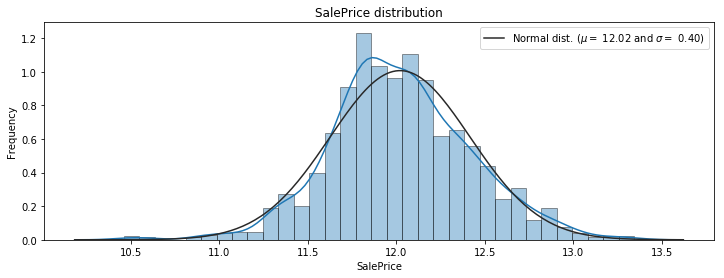

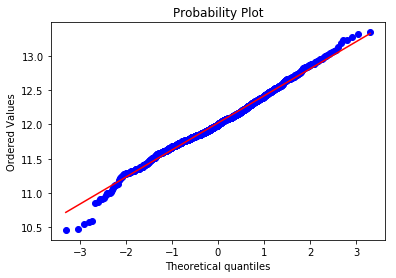

In [14]:
# Log Transformation
train['SalePrice'] = np.log1p(train['SalePrice'])

(mu, sigma) = norm.fit(train['SalePrice'])

plt.figure(figsize = (12,4))
ax = sns.distplot(train['SalePrice'], hist_kws = {'edgecolor':'black'}, fit = norm)
ax.set(title = 'SalePrice distribution', ylabel = 'Frequency')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
            loc='best')

plt.show()

stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# Feature engineering

In [15]:
# Concatenate train and test data
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values

all_data = pd.concat([train,test]).reset_index(drop = True)
all_data.drop('SalePrice', axis = 1, inplace = True)

print('all_data size is: {}'.format(all_data.shape))

all_data size is: (2915, 79)


## Missing Data

In [16]:
total = all_data.isnull().sum()
percent = (all_data.isnull().sum()/len(all_data))*100

missing_data = pd.concat([total,percent], axis = 1, keys = ['Total','Percent']).sort_values(by = 'Total', ascending = False).reset_index()
missing_data = missing_data.loc[missing_data['Total'] != 0]
missing_data

,index,Total,Percent
0,PoolQC,2907,99.73
1,MiscFeature,2810,96.40
2,Alley,2717,93.21
3,Fence,2345,80.45
4,FireplaceQu,1420,48.71
5,LotFrontage,486,16.67
6,GarageYrBlt,159,5.45
7,GarageQual,159,5.45
8,GarageFinish,159,5.45
9,GarageCond,159,5.45


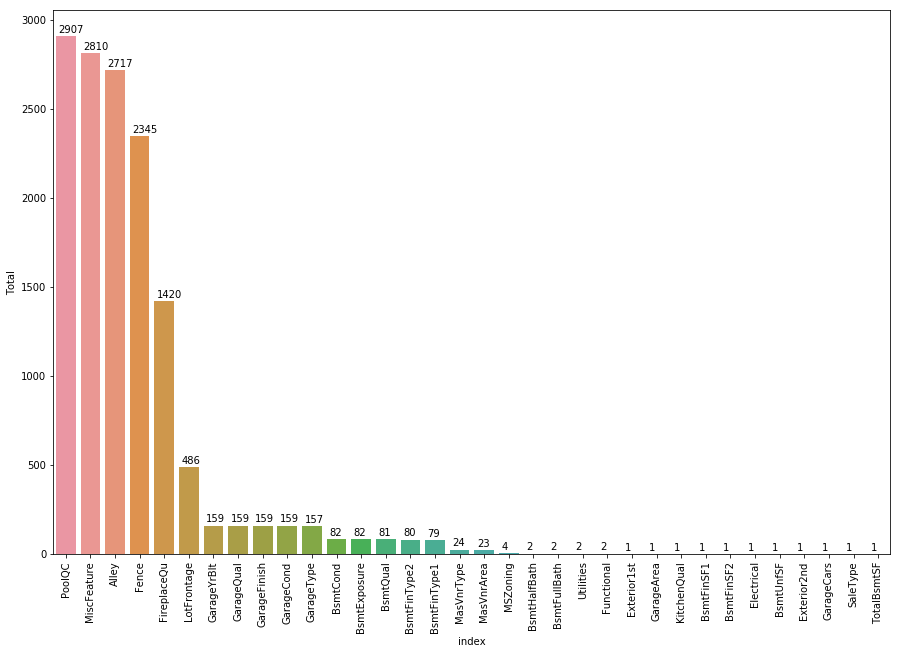

In [17]:
fig, ax = plt.subplots(figsize = (15,10))
plt.xticks(rotation = 90)
ax = sns.barplot(x='index', y='Total', data = missing_data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+0.1, height+20, '%.0f'%(height))

### Correlation

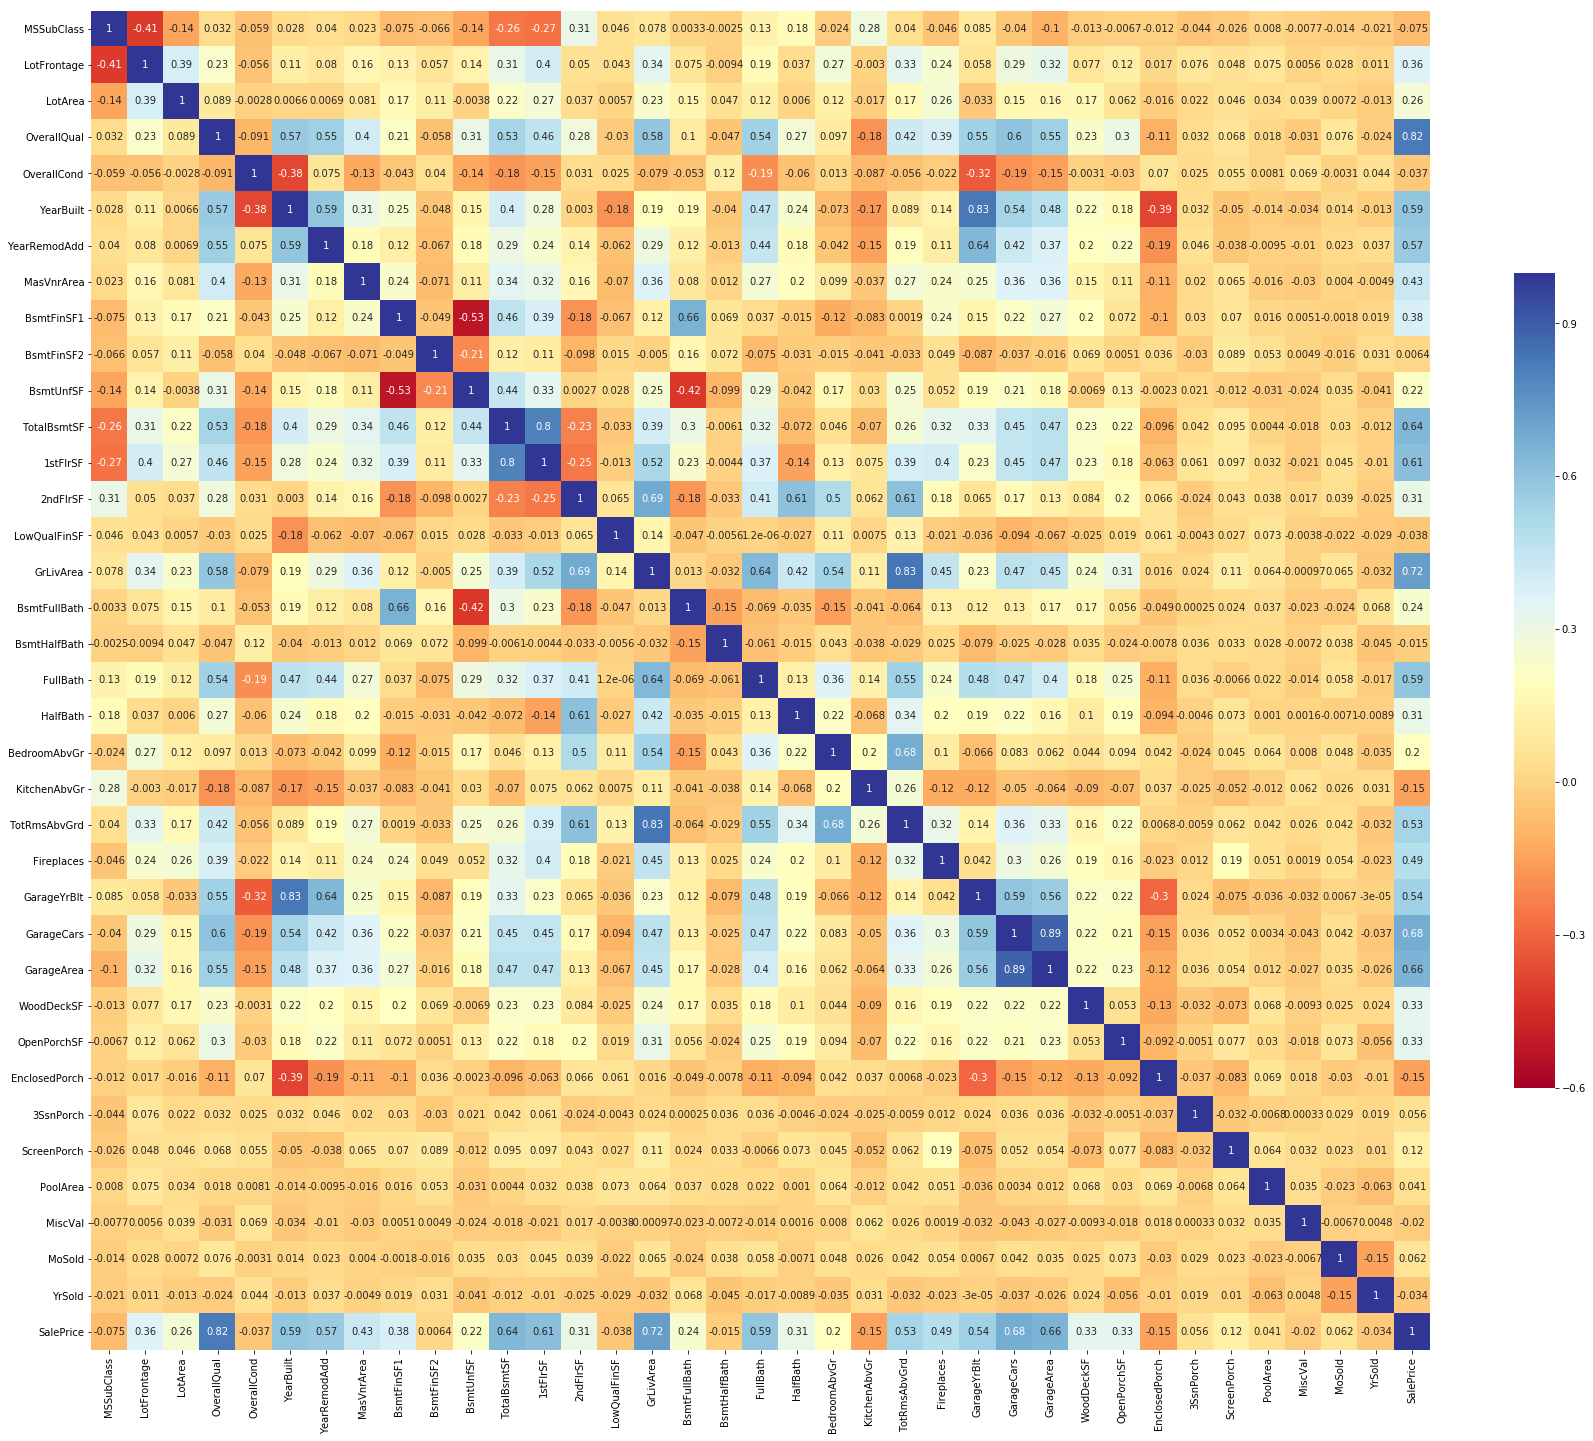

In [18]:
plt.subplots(figsize = (30,30))
sns.heatmap(train.corr(), cmap="RdYlBu", vmax = 1, vmin = -0.6, center = 0.2, square = True, linewidths=0, 
            cbar_kws={"shrink": .5}, annot = True)

### 'SalePrice' correlation matrix (zoomed heatmap style)

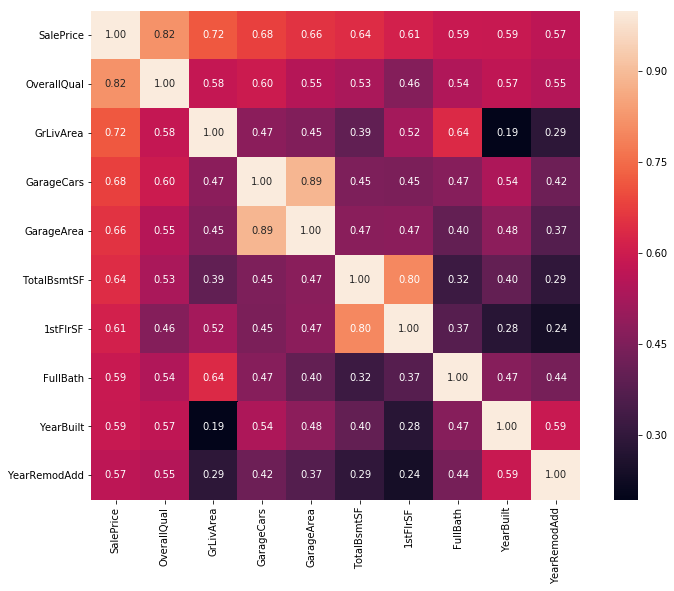

In [19]:
k=10
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

plt.figure(figsize = (12,9))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# 'GarageCars' and 'GarageArea'  - left only 'GarageCars'
# 'TotalBsmtSF' and '1stFloor' - left 'TotalBsmtSF'
# 'TotRmsAbvGrd' and 'GrLivArea' left 'GrLivArea'

### Scatterplots between SalePrice and most collelated variables

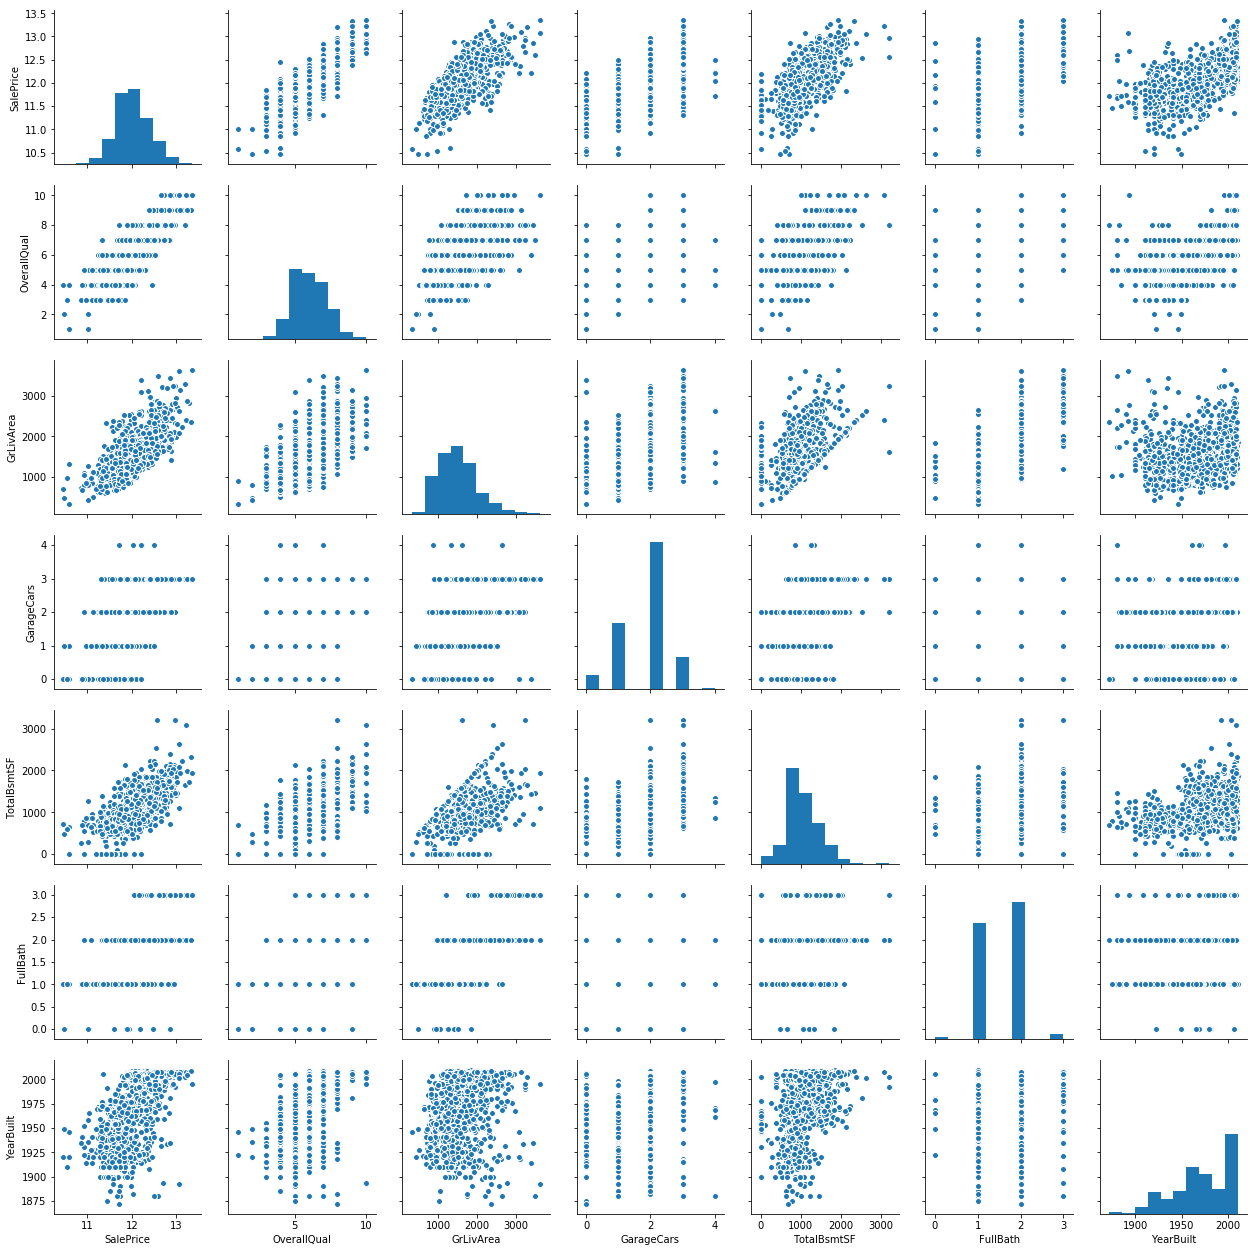

In [20]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()

### Filling missing values

In [21]:
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print('Filling with NA - Done!')


all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Filling LotFrontage - Done!')


for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print('Filling with 0 - Done!')

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print('Filling with mode - Done!')

Filling with NA - Done!
Filling LotFrontage - Done!
Filling with 0 - Done!
Filling with mode - Done!


In [22]:
all_data_na = all_data.isnull().sum().sort_values(ascending = False)
print('Feature with missing values is ', all_data_na[all_data_na != 0])

Feature with missing values is  Utilities    2
dtype: int64


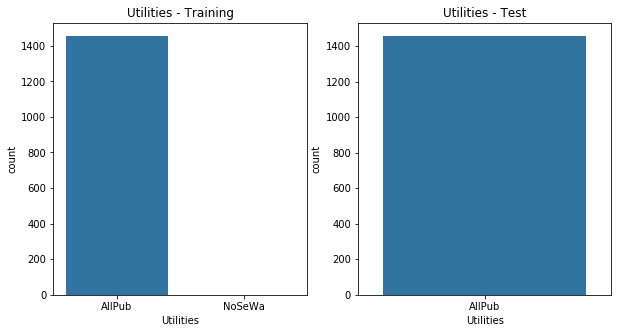

In [23]:
# Let's check the columns Utilities

plt.subplots(figsize = (10,5))
plt.subplot(1,2,1)
ax = sns.countplot(x = 'Utilities', data = train).set_title('Utilities - Training')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'Utilities', data = test).set_title('Utilities - Test')

In [24]:
# In training dataset we have 2 unique values and in test set only one unique value, so we can drop this column
all_data.drop('Utilities', axis = 1, inplace = True)

# Let's check again for missing values
all_data_na = all_data.isnull().sum().sort_values(ascending = False)
print('Feature with missing values is ', all_data_na[all_data_na != 0])

Feature with missing values is  Series([], dtype: int64)


## More feature engineering

In [25]:
# Transforming some numerical variables to categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(str)
all_data['YrSold'] = all_data['YrSold'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

### Label Encoding some categorical variables that may contain information in their ordering set

In [26]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 
        'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
    
# Check the result
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2915, 78)


In [27]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## Skewed features

In [28]:
numeric_f = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew for all numeric features
skewed_f = all_data[numeric_f].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
print('\nSkew in numerical features:')

skewness = pd.DataFrame({'Skew': skewed_f})
skewness.head(10)


Skew in numerical features:


,Skew
MiscVal,21.93
PoolArea,18.70
LotArea,13.12
LowQualFinSF,12.08
3SsnPorch,11.37
LandSlope,4.97
KitchenAbvGr,4.30
BsmtFinSF2,4.14
EnclosedPorch,4.00
ScreenPorch,3.94


### Box Cox Transformation for (highly) skewed features

In [29]:
skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Boc Cox transform'.format(skewness.shape[0]))

There are 59 skewed numerical features to Boc Cox transform


In [30]:
skewed_f = skewness.index
lam = 0.15
for feat in skewed_f:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [31]:
### Getting dummy categorical features
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2915, 220)


### Getting new train and test sets

In [32]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [33]:
# Validation function

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### MODELS

In [34]:
# Lasso regression
# may be sensitive to outliers
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))

# Elastic Net REgression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio=0.9, random_state = 3))

# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Gradient Boosting Regression
# loss = 'huber' - robust to outlier
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

#XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.05, max_depth=3,min_child_weight=1.7817, 
                             n_estimators=2200,reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1,random_state =7, 
                             nthread = -1)
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=720,max_bin = 55, 
                              bagging_fraction = 0.8,bagging_freq = 5, feature_fraction = 0.2319,feature_fraction_seed=9,
                              bagging_seed=9,min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [35]:
# Base score
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1112 (0.0073)

ElasticNet score: 0.1112 (0.0074)

Kernel Ridge score: 0.1153 (0.0076)

Gradient Boosting score: 0.1179 (0.0086)

Xgboost score: 0.1156 (0.0052)

LGBM score: 0.1152 (0.0069)



In [36]:
# Stacking models

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [37]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1089 (0.0075)



In [38]:
#Stacking model with meta model

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [39]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0071)


### Ensembling StackedRegressor, XGBoost and LightGBM

In [40]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [41]:
# Stacked Regressor

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07847471914269537


In [42]:
# XGBOOST

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07871578017371057


In [43]:
# Light GBM

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0717745819409774


In [44]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07546641468389662


### Ensembling prediction

In [45]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

### Conclusion

In [47]:
sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)